In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    lib

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    

In [4]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))    

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [5]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

In [6]:
CLIENT_ID = 'MDKTZ51MSTHC0B4LJJKK4HGKKRJF0IAGHZ4Y5WPOH3FHTHGN' 
CLIENT_SECRET = 'VJRMO15QZNBGKLP12YY4YXFVVSMPLIHJKFYQPFY0F3TNK30C' 
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MDKTZ51MSTHC0B4LJJKK4HGKKRJF0IAGHZ4Y5WPOH3FHTHGN
CLIENT_SECRET:VJRMO15QZNBGKLP12YY4YXFVVSMPLIHJKFYQPFY0F3TNK30C


In [7]:
LIMIT = 2000

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
       
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [11]:
manhattan_venues.shape

(3982, 7)

In [13]:

manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()

kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

kmeans.labels_[0:20] 

array([2, 1, 0, 1, 3, 2, 2, 0, 3, 2, 4, 2, 1, 0, 2, 0, 1, 2, 3, 3],
      dtype=int32)

In [14]:

manhattan_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

manhattan_merged = manhattan_merged.join(manhattan_grouped.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bike Trail,Bistro,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss R

In [15]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [16]:
Coffee_data = manhattan_venues[manhattan_venues['Venue Category'] == 'Coffee Shop'].reset_index(drop=True)

In [17]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(Coffee_data['Venue Latitude'], Coffee_data['Venue Longitude'], Coffee_data['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [18]:
pip install BeautifulSoup4

     |████████████████████████████████| 102kB 19.2MB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install lxml

     |████████████████████████████████| 5.8MB 24.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [20]:
from bs4 import BeautifulSoup
res = requests.get("https://www.worldatlas.com/articles/manhattan-neighborhoods-by-population.html")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
Population = pd.read_html(str(table))[0]
Population = Population.iloc[:,1:].reset_index(drop=True)
Population.columns = ['Neighborhood', 'Population']

In [21]:
import matplotlib.pyplot as plt

In [22]:
Coffee_shop_number = Coffee_data.Neighborhood.value_counts()
Coffee_shop_number = Coffee_shop_number.to_frame().reset_index()
Coffee_shop_number.columns = ['Neighborhood','Counts']

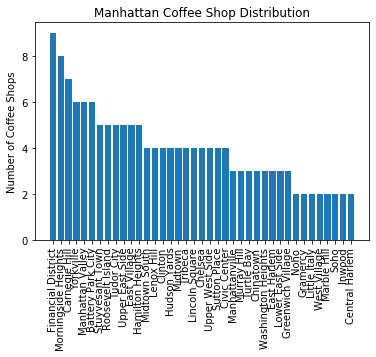

In [23]:
y_pos = np.arange(Coffee_shop_number.Neighborhood.count())
plt.bar(y_pos, Coffee_shop_number.Counts)
plt.xticks(y_pos, Coffee_shop_number.Neighborhood,rotation=90)
plt.ylabel('Number of Coffee Shops')
plt.title('Manhattan Coffee Shop Distribution')

plt.show()

In [24]:
result_2 = pd.merge(Coffee_shop_number,
                 Population,
                 on='Neighborhood', 
                 how='left', 
                 )

In [26]:
result_2['Per_capita'] = result_2.Population/result_2.Counts

In [27]:
result_2 = result_2.dropna().reset_index(drop = True)

In [31]:
result_2.head()

,Neighborhood,Counts,Population,Per_capita
0,Financial District,9,60976.0,6775.111111
1,Morningside Heights,8,55929.0,6991.125000
2,Yorkville,6,35221.0,5870.166667
3,Battery Park City,6,39699.0,6616.500000
4,Stuyvesant Town,5,21049.0,4209.800000


### Manhattan coffee shops population density by clustering

In [39]:
manhattan_merged_2 = manhattan_merged[['Neighborhood','Cluster Labels']]
result_3 = pd.merge(result_2,
                 manhattan_merged_2,
                 on='Neighborhood', 
                 how='left')

In [68]:
result_4 = result_3[['Counts','Population','Cluster Labels']].groupby('Cluster Labels').sum().reset_index()
result_4['Per Capita'] = result_4.Population / result_4.Counts

In [69]:
result_4

,Cluster Labels,Counts,Population,Per Capita
0,0,28,455964.0,16284.428571
1,1,17,305332.0,17960.705882
2,2,32,800585.0,25018.281250
3,3,10,164043.0,16404.300000
4,4,3,10284.0,3428.000000


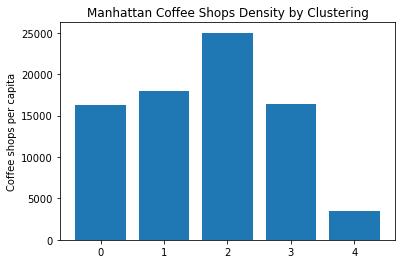

In [73]:
y_pos = np.arange(result_4.Population.count())
plt.bar(y_pos, result_4['Per Capita'])
plt.xticks(y_pos, result_4['Cluster Labels'])
plt.ylabel('Coffee shops per capita')
plt.title('Manhattan Coffee Shops Density by Clustering')

plt.show()

In [63]:
manhattan_merged_2.loc[manhattan_merged_2['Cluster Labels'] == 2]

,Neighborhood,Cluster Labels
8,Upper East Side,2
13,Lincoln Square,2
14,Clinton,2
15,Midtown,2
21,Tribeca,2
27,Gramercy,2
28,Battery Park City,2
29,Financial District,2
32,Civic Center,2
35,Turtle Bay,2


### Manhattan Population by Neighborhood

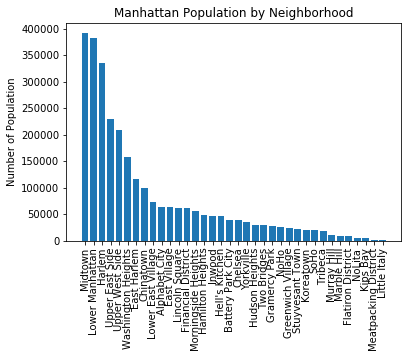

In [28]:
y_pos = np.arange(Population.Neighborhood.count())
plt.bar(y_pos, Population.Population)
plt.xticks(y_pos, Population.Neighborhood,rotation=90)
plt.ylabel('Number of Population')
plt.title('Manhattan Population by Neighborhood')

plt.show()

### Manhattan Coffee Shops Density

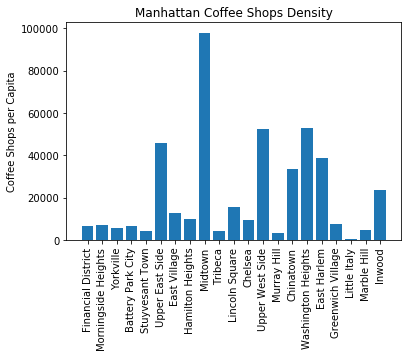

In [29]:
y_pos = np.arange(result_2.Neighborhood.count())
plt.bar(y_pos, result_2.Per_capita)
plt.xticks(y_pos, result_2.Neighborhood,rotation=90)
plt.ylabel('Coffee Shops per Capita')
plt.title('Manhattan Coffee Shops Density')

plt.show()

In [30]:
Coffee_data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
1,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop
2,Chinatown,40.715618,-73.994279,Little Canal,40.714317,-73.990361,Coffee Shop
3,Chinatown,40.715618,-73.994279,Oliver Coffee,40.712986,-73.998106,Coffee Shop
4,Chinatown,40.715618,-73.994279,Happy Bones,40.720648,-73.997125,Coffee Shop
